### Import Library ###

In [2]:
import os
import datetime
import string
import math
import typing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import csv
import sklearn.model_selection
import imgaug
from jiwer import wer, cer
import tensorflow as tf
import keras_ocr

### Global Variable ###

In [6]:
data_dir = "C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\OCR image\\Challenge2_Training_Task2_GT"
recognizer_alphabet = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
initial_lr_recognizer = 0.0001  # Initial learning rate for recognizer model
layers_num = 10

# recognizer_alphabet = "0123456789abcdefghijklmnopqrstuvwxyz!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"

### Load Dataset ###

In [52]:
def get_detector_dataset_icdar_2013(data_dir, skip_illegible=False):
    dataset = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.bmp'):
            image_path = os.path.join(data_dir, filename)
            text_path = os.path.join(data_dir, filename[:-4] + '.txt')
            lines = []

            # Load the transcriptions
            with open(text_path, 'r') as f:
                current_line: typing.List[typing.Tuple[np.ndarray, str]] = []

                for raw_row in f.read().split("\n"):
                  # Extract the bounding boxes and transcriptions
                  if raw_row == "":
                    lines.append(current_line)
                    current_line = []
                  else:
                    row = raw_row.split(" ")[5:]
                    character = row[-1][1:-1]
                    if character == "" and skip_illegible:
                        continue
                    x1, y1, x2, y2 = map(int, row[:4])
                    current_line.append(
                        (np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]]), character)
                    )

            lines = [line for line in lines if line]
            dataset.append((image_path, lines, 1))

    return dataset

In [53]:
def combine_line(line):
    text = "".join(
        [character if character is not None else "" for _, character in line]
    )
    box = np.concatenate(
        [coords[:2] for coords, _ in line]
        + [np.array([coords[3], coords[2]]) for coords, _ in reversed(line)]
    ).astype("float32")
    first_point = box[0]
    rectangle = cv2.minAreaRect(box)
    box = cv2.boxPoints(rectangle)

    # Put the points in clockwise order
    box = np.array(np.roll(box, -np.linalg.norm(box - first_point, axis=1).argmin(), 0))
    return box, text

In [54]:
def get_recognizer_dataset_icdar_2013():
    dataset = []
    for image_path, lines, _ in get_detector_dataset_icdar_2013(
        data_dir, skip_illegible=True
    ):
        for line in lines:
            box, text = combine_line(line)
            dataset.append((image_path, box, text))
    return dataset

In [8]:
# 3 option: icdar2013, born_digital, cocotext
dataset_type = "cocotext"

if dataset_type == "icdar2013":
    recognizer_dataset = get_recognizer_dataset_icdar_2013()
elif dataset_type == "born_digital":
    recognizer_dataset = keras_ocr.datasets.get_born_digital_recognizer_dataset()
elif dataset_type == "cocotext":
    recognizer_dataset = keras_ocr.datasets.get_cocotext_recognizer_dataset()

Looking for C:\Users\M-S-I\.keras-ocr\coco-text\cocotext.v2.zip


### Recognizer ###

In [45]:
train_split, test_split = sklearn.model_selection.train_test_split(
    recognizer_dataset, train_size=0.8, random_state=42
)

In [46]:
# Filter out empty words
train_labels = [
    (filepath, box, word) 
    for filepath, box, word in train_split 
    if word
]
test_labels = [
    (filepath, box, word) 
    for filepath, box, word in test_split 
    if word
]

print(f"train: {len(train_labels)}, test: {len(test_labels)}, total: {len(train_labels) + len(test_labels)}")

train: 49122, test: 12366, total: 61488


In [74]:
count_dot = 0
count_coma = 0
count_qmark = 0
count_exclamation = 0
count_quoet_1 = 0
count_quoet_2 = 0

for i in train_labels:
    if "." in i[2]:
        count_dot+=1
    elif "," in i[2]:
        count_coma+=1
    elif "?" in i[2]:
        count_qmark+=1
    elif "!" in i[2]:
        count_exclamation+=1
    elif "'" in i[2]:
        count_quoet_1+=1
    elif "\"" in i[2]:
        count_quoet_2+=1

print(f". = {count_dot}")
print(f", = {count_coma}")
print(f"? = {count_qmark}")
print(f"! = {count_exclamation}")
print(f"' = {count_quoet_1}")
print(f"\" = {count_quoet_2}")

. = 1056
, = 90
? = 16
! = 55
' = 328
" = 13


In [9]:
# Recognizer model
recognizer = keras_ocr.recognition.Recognizer(alphabet=recognizer_alphabet)

# un-comment if want to train the model again, instead of fine tuning the pretrained
recognizer.model.load_weights(f"C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights\\recognizer_{dataset_type}_first_{layers_num}.h5")

# # Define the number of layers to freeze [13, 16, 19, 22, 25]
num_layers_to_freeze = layers_num  # Freeze the first 20 layers out of 28 layers

# # Freeze the recognizer layers by setting their trainable attribute to False
for layer in recognizer.model.layers[num_layers_to_freeze:]:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr_recognizer)
recognizer.compile(optimizer=optimizer)

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\M-S-I\.keras-ocr\crnn_kurapan_notop.h5


In [12]:
recognizer.model.layers

In [76]:
# Image Generator
batch_size = 16
# augmenter = imgaug.augmenters.Sequential([
#     imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
# ])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, None), (validation_labels, None)]
]

training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    ) for image_generator in [training_image_gen, validation_image_gen]
]

In [77]:
print(f"train: {len(train_labels)}, test: {len(test_labels)}, validation: {len(validation_labels)}")

train: 39297, test: 12366, validation: 9825


1191 / 39297 instances have illegal characters.
text: Pea


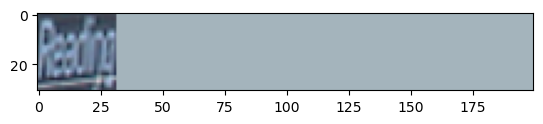

In [78]:
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(os.path.join("C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights", f'recognizer_{dataset_type}_first_{layers_num}.h5')),
    tf.keras.callbacks.CSVLogger(os.path.join("C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights", f'recognizer_{dataset_type}_first_{layers_num}.csv'), append=True),
]
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=81,
)

### Inference ###

In [4]:
recognizer_alphabet = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
dataset_type = "cocotext"
layers_num = 10

# Load a pre-trained recognizer model
recognizer1 = keras_ocr.recognition.Recognizer(alphabet=recognizer_alphabet)

# Load the fine-tuned weights
recognizer1.model.load_weights(f"C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights\\recognizer_cocotext_mid_freeze.h5")

pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer1)

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\M-S-I\.keras-ocr\crnn_kurapan_notop.h5
Looking for C:\Users\M-S-I\.keras-ocr\craft_mlt_25k.h5


1/1 [==============================] - 8s 8s/step
Predicted: 132, Actual: 13.2


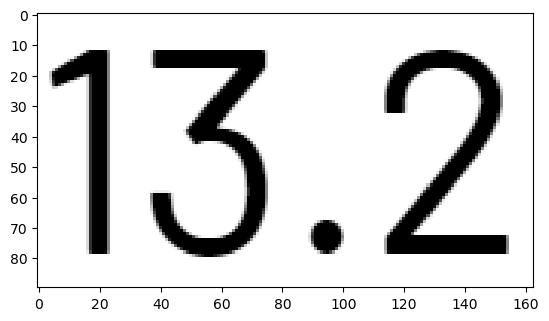

In [5]:
image_filepath, _, actual = ["C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\OCR image\\Screenshot 2024-06-04 080854.png", "", "13.2"]
predicted = recognizer1.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

1/1 [==============================] - 0s 99ms/step
Prediction: Kenapa disinigy Joni berkata masih Kamu eh 11 Halo Joni Kamu masih belum Kok pulang


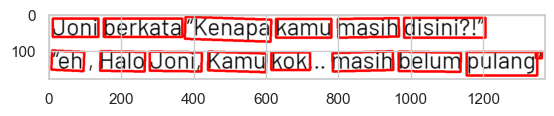

In [43]:
# image = "C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Web\\pdf2png\\Proposal Proyek Akhir - Google Docs\\page_5.png"
# image = "C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\abstrak indo.png"
image = "C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\tes special char.png"
# image = "C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\OCR image\\Screenshot 2024-06-04 080854.png"
# image = "C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\OCR image\\Screenshot 2024-06-05 113115.png"



predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=keras_ocr.tools.read(image), boxes=predictions, boxes_format='predictions'
)

pred_str = []
for prediction in predictions:
    pred_str.append(prediction[0])

print(f"Prediction: {' '.join(pred_str)}")
plt.imshow(drawn)

### Get Prediction For WER and CER ###

In [7]:
def get_text_from_filename(filename):
    # Split the filename by the underscore and take the first part
    text_part = filename.split('_')[0]
    return text_part

def predicted_func():
    # Assign directories
    image_directory = (
        "C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\OCR image\\Synthetic_Data\\synthetic_data"
    )

    # Create a CSV file for writing predictions
    with open(f"recognizer_cocotext_mid_freeze_predictions.csv", "w", newline="", encoding="utf-8") as csvfile:
        csv_writer = csv.writer(csvfile)

        # Open the label file and read actual values into an array
        actual_ar = []

        # Populate actual_ar with text from image filenames
        for filename in os.listdir(image_directory):
            if filename.endswith(".jpg"):
                text_part = get_text_from_filename(filename)
                actual_ar.append(text_part)

        # Write header to the CSV file
        csv_writer.writerow(["Filename", "Actual", "Prediction"])

        # Iterate over files in the directory and actual values simultaneously
        for filename, actual_value in zip(os.listdir(image_directory), actual_ar):
            if filename.endswith(".jpg"):
                # Get prediction
                predictions = pipeline.recognize(
                    images=[os.path.join(image_directory, filename)]
                )[0]
                # print(filename)
                try:
                    # Write filename, actual value, and prediction to CSV
                    csv_writer.writerow([filename, actual_value, predictions[0][0]])
                except IndexError:
                    csv_writer.writerow(
                        [filename, actual_value, ""]
                    )  # Empty string if no prediction

# Call the function to write predictions to CSV
predicted_func()

1/1 [==============================] - 0s 84ms/step


In [32]:
import pandas as pd
from jiwer import wer, cer

def calculate_error_rates(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Extract actual and prediction columns
    actual_texts = df['Actual'].tolist()
    actual_texts = [str(item) for item in actual_texts]
    predicted_texts = df['Prediction'].tolist()
    predicted_texts = [str(item) for item in predicted_texts]

    # Calculate Word Error Rate (WER)
    word_error_rate = wer(actual_texts, predicted_texts)

    # Calculate Character Error Rate (CER)
    character_error_rate = cer(actual_texts, predicted_texts)

    return word_error_rate, character_error_rate

In [33]:
# Pretrained
# Path to your CSV file
csv_file = f"C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\ocr_results_10000_image\\recognizer_default_predictions.csv"

# Calculate and print WER and CER
wer_, cer_ = calculate_error_rates(csv_file)
print(f"WER: {wer_*100:.2f}%, CER: {cer_*100:.2f}%")

results = {"Pretrained": {"WER": wer_*100 , "CER": cer_*100}}

WER: 34.11%, CER: 7.25%


In [34]:
layers_num = [13, 16, 19, 22, 25]
i = 0
for num in layers_num:
    i+=1
    # Path to your CSV file
    csv_file = f"C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\ocr_results_10000_image\\recognizer_cocotext_{num}_predictions.csv"

    # Calculate and print WER and CER
    wer_, cer_ = calculate_error_rates(csv_file)
    results[f'KerasOCR_{i}'] = {"WER": wer_*100, "CER": cer_*100}

In [35]:
# KerasOCR_6
# Path to your CSV file
csv_file = f"C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\ocr_results_10000_image\\recognizer_cocotext_mid_freeze_predictions.csv"

# Calculate and print WER and CER
wer_, cer_ = calculate_error_rates(csv_file)
print(f"WER: {wer_*100:.2f}%, CER: {cer_*100:.2f}%")

results['KerasOCR_6'] = {"WER": wer_*100, "CER": cer_*100}

WER: 25.93%, CER: 10.68%


In [36]:
results

{'Pretrained': {'WER': 34.11, 'CER': 7.253335599558087},
 'KerasOCR_1': {'WER': 40.81, 'CER': 13.602659981303647},
 'KerasOCR_2': {'WER': 41.730000000000004, 'CER': 14.077504886547123},
 'KerasOCR_3': {'WER': 41.04, 'CER': 13.538922410130025},
 'KerasOCR_4': {'WER': 77.58, 'CER': 29.034588255290217},
 'KerasOCR_5': {'WER': 80.05, 'CER': 23.4352426276876},
 'KerasOCR_6': {'WER': 25.929999999999996, 'CER': 10.679230050140223}}

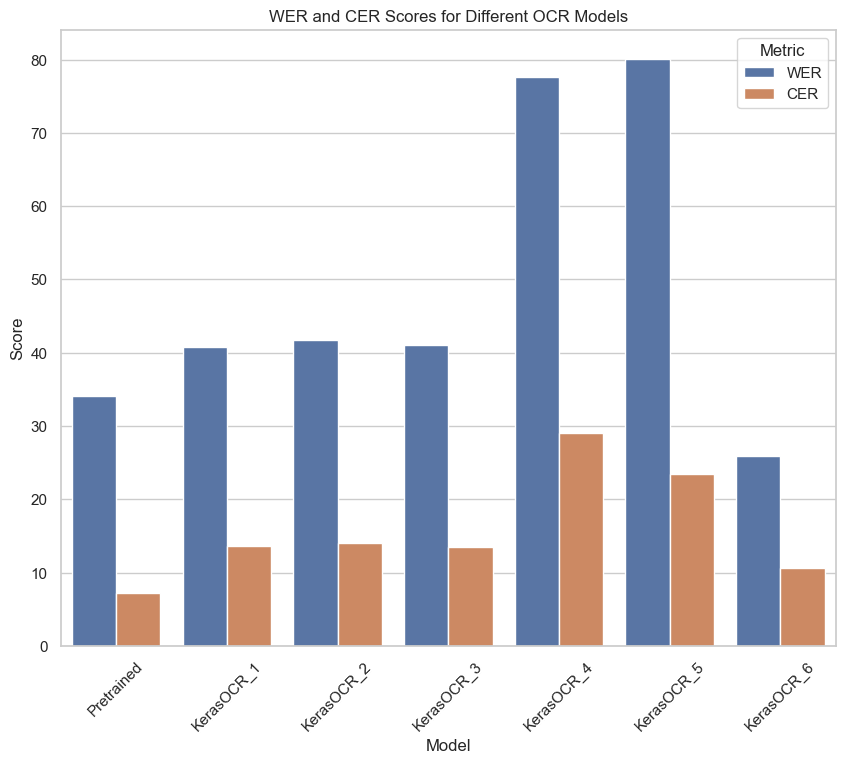

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame
df_metrics = pd.DataFrame(results).T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Rename columns
df_metrics.columns = ['Model', 'Metric', 'Score']

# Set the plot style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_metrics)

# Set the plot labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('WER and CER Scores for Different OCR Models')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


### Plot Loss & Accuracy ###

KerasOCR_1 (13 Layers)
Loss Average: 4.281741998195648
Validation Loss Average: 8.41471107006073


KerasOCR_2 (16 Layers)
Loss Average: 3.420128841399999
Validation Loss Average: 8.537518439299998


KerasOCR_3 (19 Layers)
Loss Average: 6.67195757393617
Validation Loss Average: 7.017293615510639


KerasOCR_4 (22 Layers)
Loss Average: 7.6883471203
Validation Loss Average: 7.643375091580001


KerasOCR_5 (25 Layers)
Loss Average: 9.980466165463769
Validation Loss Average: 9.178905030913043


KerasOCR_6 (Pooling & Convolutional Layers)
Loss Average: 5.3128405119243425
Validation Loss Average: 5.787465321390252




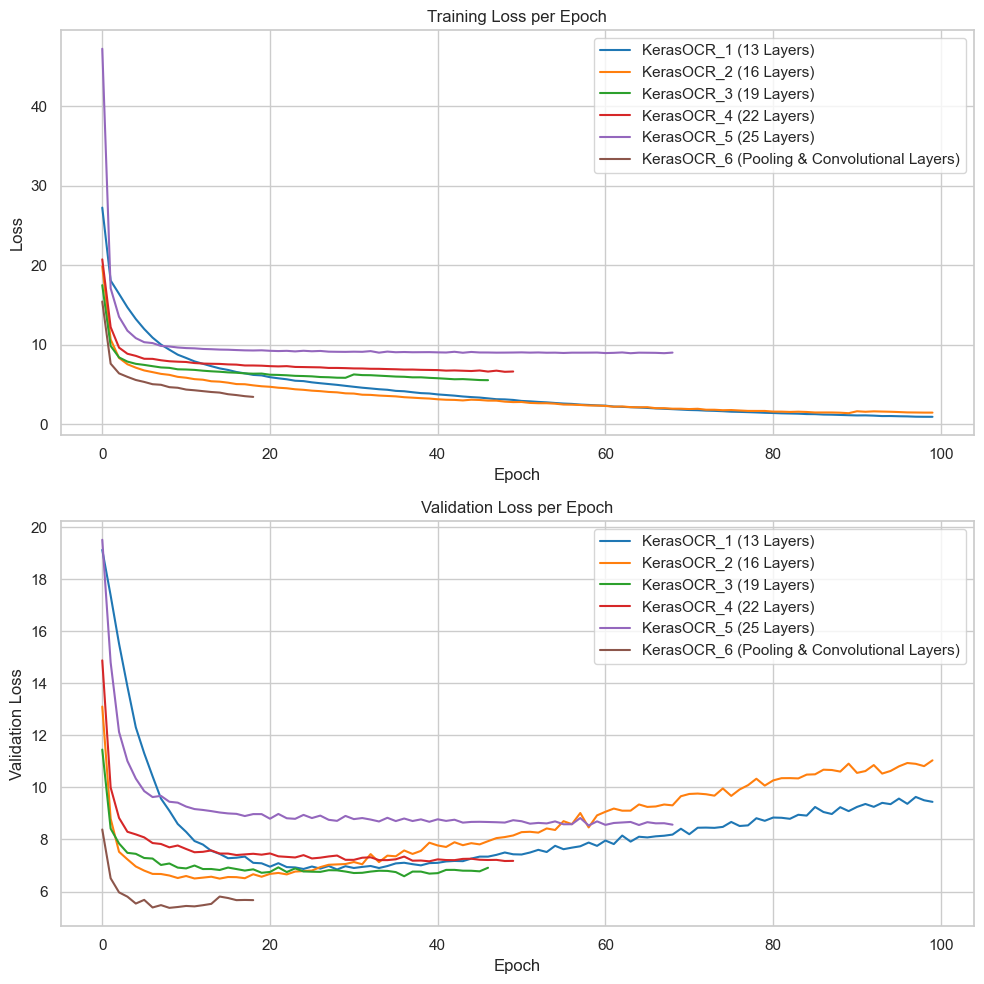

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# List of CSV files
csv_files = [
    'C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights\\recognizer_cocotext_13.csv',
    'C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights\\recognizer_cocotext_16.csv',
    'C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights\\recognizer_cocotext_19.csv',
    'C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights\\recognizer_cocotext_22.csv',
    'C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights\\recognizer_cocotext_25.csv',
    'C:\\Users\\M-S-I\\Documents\\IBDA Semester 8\\Skripsi\\Machine Learning\\model\\keras_ocr_weights\\recognizer_cocotext_mid_freeze.csv'
]

# Custom labels for the legend
custom_labels = [
    'KerasOCR_1 (13 Layers)',
    'KerasOCR_2 (16 Layers)',
    'KerasOCR_3 (19 Layers)',
    'KerasOCR_4 (22 Layers)',
    'KerasOCR_5 (25 Layers)',
    'KerasOCR_6 (Pooling & Convolutional Layers)'
]

# Colors for each file
colors = plt.cm.tab10.colors

# Create a figure with 2 subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Iterate over CSV files and plot the data
for i, file in enumerate(csv_files):
    df = pd.read_csv(file)

    print(custom_labels[i])
    print(f"Loss Average: {np.average(df['loss'])}")
    print(f"Validation Loss Average: {np.average(df['val_loss'])}")
    print(f"")
    print("")

    # Plotting loss
    ax[0].plot(df['epoch'], df['loss'], label=custom_labels[i], color=colors[i % len(colors)])
    
    # Plotting validation loss
    ax[1].plot(df['epoch'], df['val_loss'], label=custom_labels[i], color=colors[i % len(colors)])

# Customize the first subplot (loss)
ax[0].set_title('Training Loss per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')

# Customize the second subplot (validation loss)
ax[1].set_title('Validation Loss per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation Loss')
ax[1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()